1. Install and Setup

In [3]:
import pandas as pd

data = pd.read_csv("C:/Users/my/Desktop/WELFake_Dataset.csv")

3. Data Loading and Preprocessing

In [4]:
import pandas as pd

# Check the Data
print(data.head())
print(data.columns)


   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  
Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')


I have renamed a column because HuggingFace transformers recognize 'labels rather than 'label' as target column name.

In [5]:
data.drop('Unnamed: 0',axis=1,inplace=True)

data.rename(columns={'label':'labels'},inplace=True)

data.head()

,title,text,labels
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [6]:
data.shape

(72134, 3)

In [7]:
# Null values
data.isna().sum()

title     558
text       39
labels      0
dtype: int64

In [8]:
# 결측값 제거
data.dropna(subset=['title', 'text'], inplace=True)
data.dropna(axis=0,inplace=True)
# 결과 확인
print(data.shape)
print(data.isna().sum())

(71537, 3)
title     0
text      0
labels    0
dtype: int64


In [9]:
# 중복된 행 개수 확인
print(f"Number of duplicate rows: {data.duplicated().sum()}")

# 중복된 행 제거
data.drop_duplicates(inplace=True)
print(f"Data shape after removing duplicates: {data.shape}")

Number of duplicate rows: 8416
Data shape after removing duplicates: (63121, 3)


In [10]:
# Shuffle the dataframe
data = data.sample(frac=1,random_state=42)

In [11]:
data.head()

,title,text,labels
71361,Donald Trump Responds To Mockery Over Fake Sw...,"Last night, at a rally in Melbourne, Florida, ...",1
11496,Tweetwave,This time it's true no pantsTweetwave More Of ...,1
20292,Rubio says prospect of Trump president is 'wor...,(Reuters) - U.S. Senator Marco Rubio said on W...,0
38855,Trump lifts Cyber Command status to boost cybe...,WASHINGTON (Reuters) - President Donald Trump ...,0
20416,The 7 Biggest Republican Lies About The Econo...,"In two-and-a-half minutes, former U.S. Secreta...",1


## 4. Exploratory Data Analysis

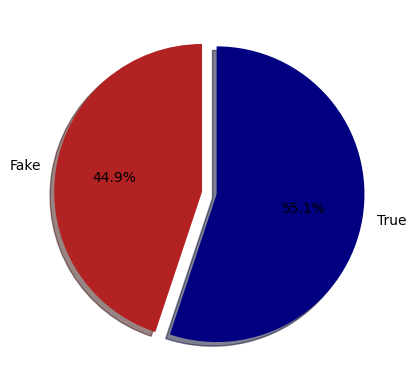

In [12]:
import matplotlib.pyplot as plt

# 데이터 준비
label_size = [data['labels'].sum(), len(data['labels']) - data['labels'].sum()]

# 파이 차트 그리기
plt.pie(label_size, 
        explode=[0.1, 0], 
        colors=['firebrick', 'navy'], 
        startangle=90, 
        shadow=True, 
        labels=['Fake', 'True'], 
        autopct='%1.1f%%')

# 그래프 표시
plt.show()

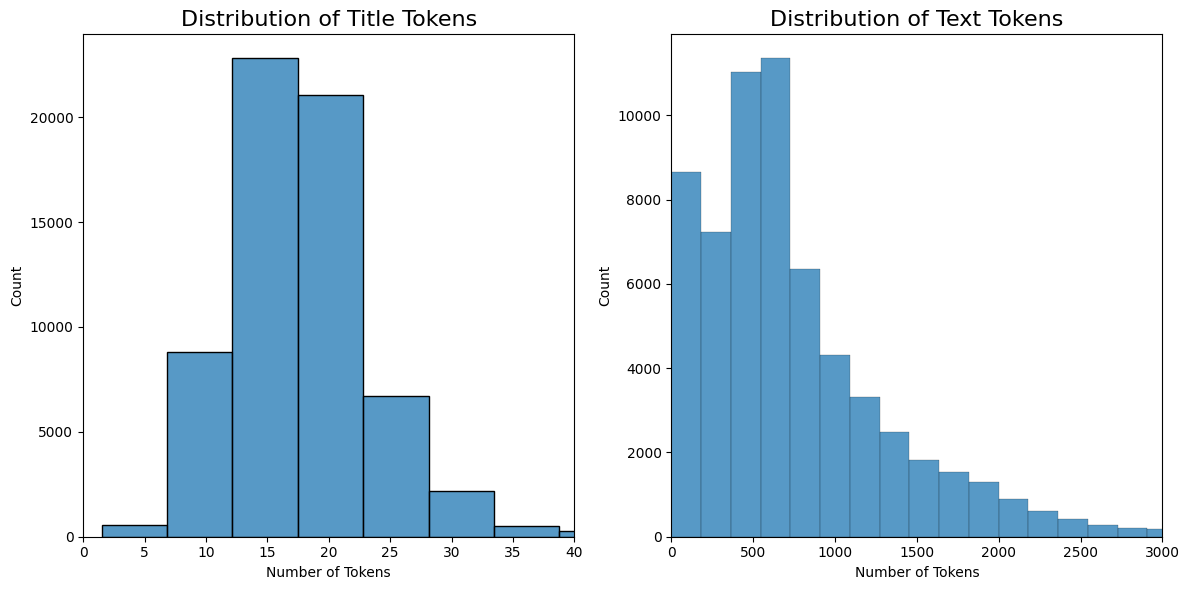

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Token 계산: 각 단어 수에 평균적으로 1.5를 곱해 토큰 수 추정
title_token_counts = data['title'].map(lambda text: len(text.split()) * 1.5)
text_token_counts = data['text'].map(lambda text: len(text.split()) * 1.5)

# 플롯 생성
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 제목 토큰 분포 시각화
sns.histplot(title_token_counts, bins=20, ax=axes[0])
axes[0].set_title("Distribution of Title Tokens", fontsize=16)
axes[0].set_xlabel("Number of Tokens")
axes[0].set_xlim(0, 40)

# 본문 토큰 분포 시각화
sns.histplot(text_token_counts, bins=200, ax=axes[1])
axes[1].set_title("Distribution of Text Tokens", fontsize=16)
axes[1].set_xlabel("Number of Tokens")
axes[1].set_xlim(0, 3000)

# 레이아웃 조정
plt.tight_layout()
plt.show()


The token distribution for titles is more concentrated and smaller in range, making it computationally efficient for model training. On the other hand, the token distribution for texts is broader, indicating higher variability and larger input sizes, which could increase the computational cost when processing with models like BERT.

In [18]:

from transformers import BertTokenizer
import pandas as pd

# 1. 데이터 로드
titles = data['title']

# 2. 텍스트 정제 함수
def clean_text(text):
    # 특수문자 제거
    text = ''.join(c for c in text if c.isalnum() or c.isspace())
    # 소문자 변환
    text = text.lower()
    return text

# 정제된 Title 데이터로 변환
cleaned_titles = titles.apply(clean_text)

# 3. BERT 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 4. 토큰화, 패딩 및 트렁케이션 처리
max_length = 32  # 고정 시퀀스 길이 설정
encoded_titles = tokenizer(
    cleaned_titles.tolist(),  # 리스트 형태로 변환
    padding='max_length',     # 고정 길이로 패딩
    truncation=True,          # 길이를 초과하면 자름
    max_length=max_length,    # 최대 길이 설정
    return_tensors="pt"       # PyTorch 텐서로 반환 (TensorFlow는 "tf")
)

# 5. 출력 형태 확인
print(encoded_titles.keys())  # 'input_ids', 'attention_mask', 'token_type_ids' 포함
print(encoded_titles['input_ids'][0])  # 첫 번째 샘플의 토큰 ID 출력

# 6. 결과 (PyTorch 텐서) 예시
input_ids = encoded_titles['input_ids']
attention_mask = encoded_titles['attention_mask']




ImportError: Unable to convert output to PyTorch tensors format, PyTorch is not installed.

In [23]:
git clone --recursive https://github.com/pytorch/pytorch
cd pytorch






SyntaxError: invalid syntax (2019170356.py, line 1)

In [26]:
!conda install -c pytorch-test torchvision




'conda'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [22]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)


ModuleNotFoundError: No module named 'torch'

In [38]:
# 데이터셋에서 'title'과 'text' 컬럼을 토큰화
def tokenize_function(examples):
    title_tokens = tokenizer(examples['title'], padding=True, truncation=True, max_length=500)
    text_tokens = tokenizer(examples['text'], padding=True, truncation=True, max_length=500)
    return {
        'input_ids': title_tokens['input_ids'] + text_tokens['input_ids'],  # title과 text를 합침
        'attention_mask': title_tokens['attention_mask'] + text_tokens['attention_mask']
    }

data['tokens'] = data.apply(lambda row: tokenize_function(row), axis=1)

# 'input_ids'와 'attention_mask' 컬럼을 분리하여 저장
data['input_ids'] = data['tokens'].apply(lambda x: x['input_ids'])
data['attention_mask'] = data['tokens'].apply(lambda x: x['attention_mask'])

# 토큰화 결과 일부 확인
print(data[['title', 'input_ids', 'attention_mask']].head())



                                                   title  \
71361   Donald Trump Responds To Mockery Over Fake Sw...   
11496                                          Tweetwave   
20292  Rubio says prospect of Trump president is 'wor...   
38855  Trump lifts Cyber Command status to boost cybe...   
20416   The 7 Biggest Republican Lies About The Econo...   

                                               input_ids  \
71361  [101, 6221, 8398, 16412, 2000, 12934, 7301, 20...   
11496  [101, 1056, 28394, 2102, 16535, 102, 101, 2023...   
20292  [101, 14548, 3695, 2758, 9824, 1997, 8398, 234...   
38855  [101, 8398, 13695, 16941, 3094, 3570, 2000, 12...   
20416  [101, 1996, 1021, 5221, 3951, 3658, 2055, 1996...   

                                          attention_mask  
71361  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
11496  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
20292  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
38855  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [39]:
# 'title'과 'text'의 평균 토큰 수
title_tokens_count = data['input_ids'].apply(len)
text_tokens_count = data['text'].apply(lambda x: len(tokenizer(x)['input_ids']))

print(f"Title - 평균 토큰 수: {title_tokens_count.mean()}, 최대 토큰 수: {title_tokens_count.max()}")
print(f"Text - 평균 토큰 수: {text_tokens_count.mean()}, 최대 토큰 수: {text_tokens_count.max()}")


Title - 평균 토큰 수: 410.8943933080908, 최대 토큰 수: 609
Text - 평균 토큰 수: 702.732101836156, 최대 토큰 수: 118424


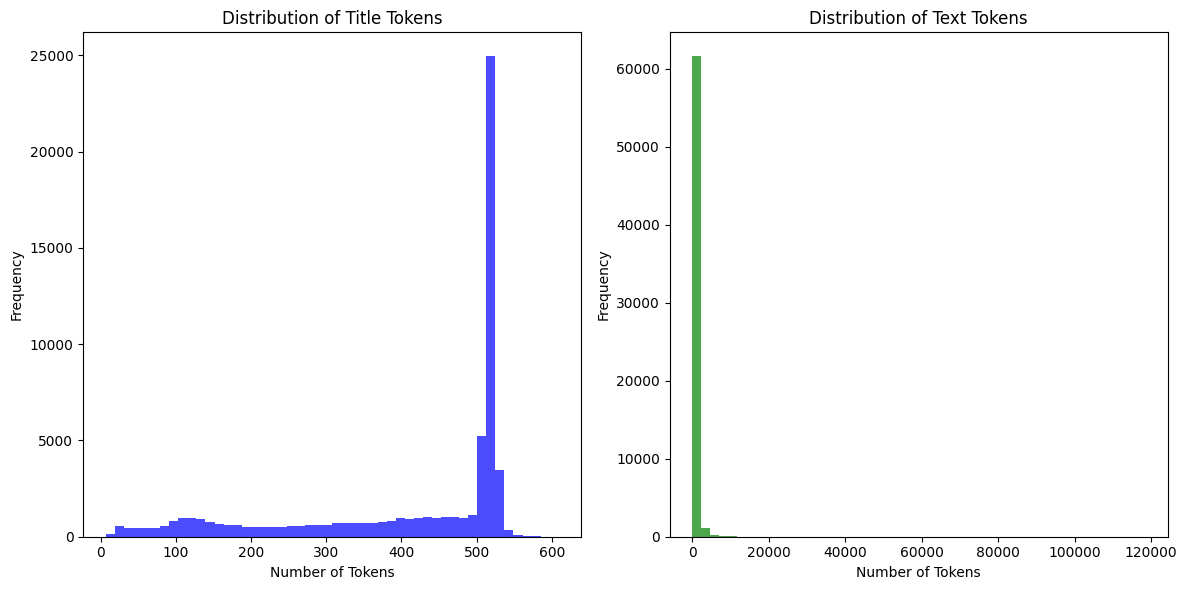

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# 'title'의 토큰 수 히스토그램
plt.subplot(1, 2, 1)  # 1행 2열, 첫 번째 subplot
plt.hist(title_tokens_count, bins=50, alpha=0.7, color='b')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Distribution of Title Tokens')

# 'text'의 토큰 수 히스토그램
plt.subplot(1, 2, 2)  # 1행 2열, 두 번째 subplot
plt.hist(text_tokens_count, bins=50, alpha=0.7, color='g')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Distribution of Text Tokens')

# 그래프 레이아웃 자동 조정
plt.tight_layout()
plt.show()
